## Figure 6 - pool time series

In [1]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
from matplotlib.lines import Line2D
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 1D arrays size nz
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T[:])) - alpha*(T[:]) + beta*(S[:]))
    return rho

def call_rho(t,state,zslice,xind,yind):
    T = state.Temp.isel(T=t,Z=zslice,X=xind,Y=yind)
    S = state.S.isel(T=t,Z=zslice,X=xind,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

In [4]:
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

state_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
stateA = xr.open_dataset(state_fileA)
state_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/stateGlob.nc'
stateB = xr.open_dataset(state_fileB)

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]

with Dataset(grid_fileA, 'r') as nbl:
        drC_A = nbl.variables['drC'][:] 

with Dataset(grid_fileB, 'r') as nbl:
        drC_B = nbl.variables['drC'][:] 
        

tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
sb_conc_A = np.empty(len(labels))
sb_conc_B = np.empty(len(labels))
sb_curv_A = np.empty(len(labels))
sb_curv_B = np.empty(len(labels))
sb_grad_A = np.empty(len(labels))
sb_grad_B = np.empty(len(labels))
sb_curv0_A = np.empty(len(labels))
sb_curv0_B = np.empty(len(labels))
sb_grad0_A = np.empty(len(labels))
sb_grad0_B = np.empty(len(labels))
sb_curvtop_A = np.empty(len(labels))
sb_curvtop_B = np.empty(len(labels))
sb_gradtop_A = np.empty(len(labels))
sb_gradtop_B = np.empty(len(labels))

for ii, trac in zip(range(len(tracers)),tracers):
    for pfile,sb_array,grad_array,curv_array,grad0_array,curv0_array,\
    gradtop_array,curvtop_array,sb_ind,drc,state in zip([ptr_fileA, ptr_fileB],
                                                        [sb_conc_A, sb_conc_B],
                                                        [sb_grad_A, sb_grad_B],
                                                        [sb_curv_A, sb_curv_B],
                                                        [sb_grad0_A, sb_grad0_B],
                                                        [sb_curv0_A, sb_curv0_B],
                                                        [sb_gradtop_A, sb_gradtop_B],
                                                        [sb_curvtop_A, sb_curvtop_B],
                                                        [sb_Ast, sb_Bar],
                                                        [drC_A, drC_B],
                                                        [stateA, stateB]):
        with Dataset(pfile, 'r') as nbl:
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = 1E-3*nbl.variables[trac][0,:,10,180] # nM to muM
              
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profile = density.data*profile.data/1000 # mumol/kg muM to 
            else:
                tr_profile = nbl.variables[trac][0,:,10,180] # muM
            
            tr_curv = (tr_profile[2:]-2*tr_profile[1:-1]+tr_profile[:-2])/(drc[3:]*drc[1:-2])
            tr_grad = (tr_profile[2:]-tr_profile[:-2])/(drc[3:]+drc[1:-2])
                
            sb_array[ii] = tr_profile[sb_ind]
            curv_array[ii] = np.nanmean(tr_curv[sb_ind-8:sb_ind+8]) # background mean 
            curvtop_array[ii] = np.nanmean(tr_curv[sb_ind-8:sb_ind]) # above canyon mean
            curv0_array[ii] = np.nanmean(tr_curv[sb_ind-1:sb_ind+5]) # local mean
            grad_array[ii] = np.nanmean(tr_grad[sb_ind-8:sb_ind+8])
            gradtop_array[ii] = np.nanmean(tr_grad[sb_ind-8:sb_ind]) 
            grad0_array[ii] = np.nanmean(tr_grad[sb_ind-1:sb_ind+5]) 
                        

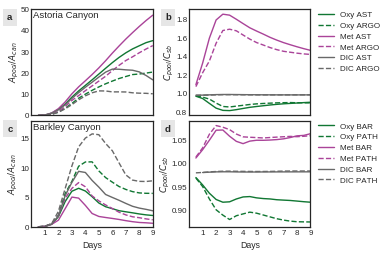

In [6]:
sns.set_style('white')
sns.set_context('paper')
fig=plt.figure(figsize=(5,4))

gs = gspec.GridSpec(2, 2, hspace=0.05,wspace=0.3)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
   
axs = [ax0,ax1,ax2,ax3]
nt = 19
labels_exp = ['AST', 'ARGO', 'BAR', 'PATH']
labels_tra = ['Oxy','Met','DIC']
units = ['(umol/kg)m3/s','(nM)m3/s','(umol/kg)m3/s']


factors = [1,1E-3,1]


exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']

exp_files_BAC = ['../saved_calcs/BAC_AST.nc',
                 '../saved_calcs/BAC_ARGO.nc',
                 '../saved_calcs/BAC_BAR.nc',
                 '../saved_calcs/BAC_PATH.nc']

colours = ['#117733','#AA4499','dimgray']

can_Area = [1.8E8, 1.8E8, 8.7E7, 8.7E7]
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]

for tr, unit, tr_lab, factor, ii, trac, col in zip(tracers, units, labels_tra, factors, [2,7,8],
                                                   tracers, colours):
    for file,file_bac, lab_exp, can_area, sb_c in zip(exp_files, exp_files_BAC, labels_exp, can_Area, sb_conc):
        
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            conc = nbl.variables['conc']
            if can_area > 8.8E7:
                if lab_exp=='AST':
                    ax0.plot(np.arange(nt)/2,area[ii,:]/can_area, '-', color = col, 
                             label = tr_lab+' '+lab_exp) 
                    ax1.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '-', color = col,
                             label = tr_lab+' '+lab_exp)
                else:
                    ax0.plot(np.arange(nt)/2,area[ii,:]/can_area, '--', color = col, 
                             label = tr_lab+' '+lab_exp) 
                    ax1.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '--', color = col,
                             label = tr_lab+' '+lab_exp)
            else:
                if lab_exp=='BAR':
                    ax2.plot(np.arange(nt)/2,area[ii,:]/can_area, '-', color = col, 
                             label = tr_lab+' '+lab_exp)
                    ax3.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '-', color = col,
                             label = tr_lab+' '+lab_exp)
                else:
                    ax2.plot(np.arange(nt)/2,area[ii,:]/can_area, '--', color = col,
                             label = tr_lab+' '+lab_exp)
                    ax3.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '--', color = col,
                             label = tr_lab+' '+lab_exp)
        
        
#         with Dataset(file_bac,'r') as nbl:
#             bac = nbl.variables['bac']
#             bac_noc = nbl.variables['bac_noc']
#             if can_area > 9E7:
#                 if lab_exp=='Astoria':
#                     ax2.plot(np.arange(nt)/2,bac[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+lab_exp)
#                     ax3.plot(np.arange(nt)/2,100*(bac[ii,:]-bac_noc[ii,:])/bac_noc[ii,:], '-',
#                                  color = col, label = tr_lab+' '+lab_exp)
#                 else:
#                     ax2.plot(np.arange(nt)/2,bac[ii,:]*factor/sb_c[ii], '--', color = col, label = tr_lab+lab_exp)
#                     ax3.plot(np.arange(nt)/2,100*(bac[ii,:]-bac_noc[ii,:])/bac_noc[ii,:], '--',
#                                  color = col, label = tr_lab+' '+lab_exp)
#             else:
#                 if lab_exp=='Barkley':
#                     ax6.plot(np.arange(nt)/2,bac[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+lab_exp) 
#                     ax7.plot(np.arange(nt)/2,100*(bac[ii,:]-bac_noc[ii,:])/bac_noc[ii,:], '-',
#                                  color = col, label = tr_lab+' '+lab_exp)
#                 else:
#                     ax6.plot(np.arange(nt)/2,bac[ii,:]*factor/sb_c[ii], '--', color = col, label = tr_lab+lab_exp) 
#                     ax7.plot(np.arange(nt)/2,100*(bac[ii,:]-bac_noc[ii,:])/bac_noc[ii,:], '--',
#                                  color = col, label = tr_lab+' '+lab_exp)
                    

ylabels = ['$A_{pool}/A_{can}$', '$C_{pool}/C_{sb}$','$A_{pool}/A_{can}$', '$C_{pool}/C_{sb}$' ]

for ax,ylab in zip([ax0,ax1,ax2,ax3], ylabels): 
    ax.set_ylabel(ylab)
    ax.set_ylabel(ylab, labelpad=0)
    ax.yaxis.set_tick_params(pad=2)
    ax.xaxis.set_ticks([])
    ax.set_xlim(0,9)

ax2.set_xlabel('Days')
ax2.xaxis.set_ticks([1,2,3,4,5,6,7,8,9])
ax3.set_xlabel('Days')
ax3.xaxis.set_ticks([1,2,3,4,5,6,7,8,9])
ax2.xaxis.set_tick_params(pad=3)
ax3.xaxis.set_tick_params(pad=3)
ax2.set_ylim(0,18)
ax0.set_ylim(0,50)
#     ax.set_ylabel(ylab)
#     ax.set_ylabel(ylab, labelpad=0)
#     ax.yaxis.set_tick_params(pad=2)

ax1.legend(bbox_to_anchor=(1,1.05),labelspacing=0.4 )
ax3.legend(bbox_to_anchor=(1,1.05),labelspacing=0.4 )

ax0.text(0.01,0.92,'Astoria Canyon',transform=ax0.transAxes)    
ax2.text(0.01,0.92,'Barkley Canyon',transform=ax2.transAxes)    
ax0.text(-0.2,0.90,'a',fontweight='bold',transform=ax0.transAxes,bbox=dict(facecolor='0.9', edgecolor='None') )    
ax1.text(-0.2,0.90,'b',fontweight='bold',transform=ax1.transAxes,bbox=dict(facecolor='0.9', edgecolor='None') )    
ax2.text(-0.2,0.90,'c',fontweight='bold',transform=ax2.transAxes,bbox=dict(facecolor='0.9', edgecolor='None') )    
ax3.text(-0.2,0.90,'d',fontweight='bold',transform=ax3.transAxes,bbox=dict(facecolor='0.9', edgecolor='None') )    

plt.savefig('fig_pool_ts.eps',format='eps', bbox_inches='tight')